In [6]:
#my libraries
from tools import (Metrics, 
                   real_vol, 
                   resample)

from ML_library import (GarchRegressor,
                        EWMARegressor,
                        MaxGarchEWMARegressor)
#classic python libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.metrics.pairwise import rbf_kernel
from scipy.optimize import minimize
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit

In [7]:
plt.rcParams['figure.figsize'] = [15, 6]
sns.set_theme(style="whitegrid")

In [8]:
### loading the S&P 500 index
ticker = '^GSPC'
start_date = '1927-12-31'
end_date = '2025-05-01'

df_SP = yf.download(tickers = ticker, start = start_date, end = end_date)
df_SP = df_SP.xs("^GSPC", axis = 1, level = "Ticker")
df_SP = df_SP[['Close']]
df_SP['Return'] = np.log(df_SP['Close']/df_SP['Close'].shift(1))
df_SP.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,Return
Date,,
1928-01-03,17.760000,NaN
1928-01-04,17.719999,-0.002255
1928-01-05,17.549999,-0.009640
1928-01-06,17.660000,0.006248
1928-01-09,17.500000,-0.009101


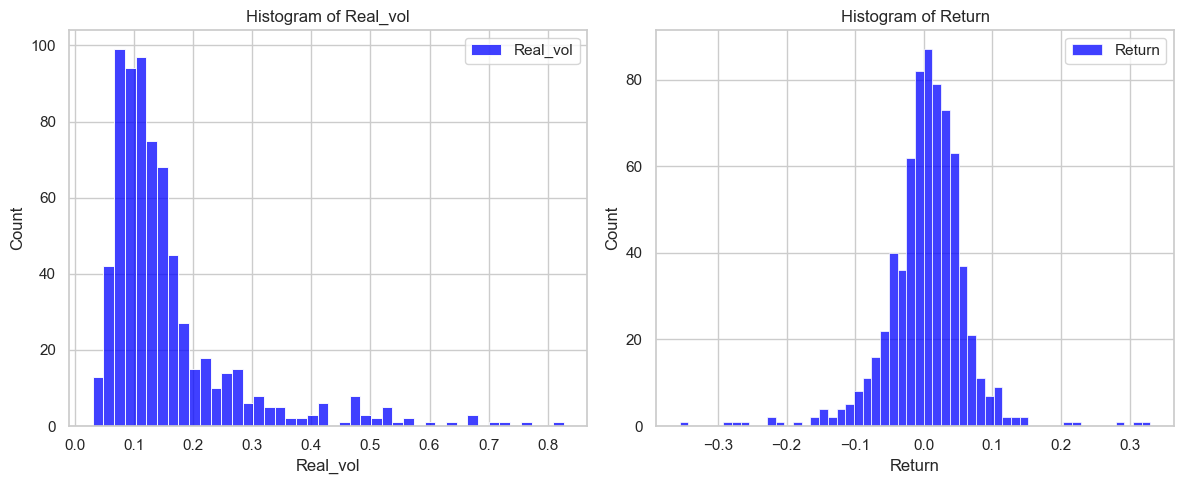

In [9]:
### splitting training set and test set
df_resampled = resample(df_SP, period = 'M')
split_train = int(len(df_resampled)*0.6)
split_test = int(len(df_resampled)*0.8)

X, y = df_resampled.shift(1).dropna(), df_resampled['Real_vol'].iloc[1:]
training_x, training_y = X.iloc[:split_train], y.iloc[:split_train]
val_x, val_y = X.iloc[split_train:split_test], y.iloc[split_train:split_test]
test_x, test_y = X.iloc[split_test:], y.iloc[split_test:]

fig, axes = plt.subplots(1, len(training_x.columns), figsize=(12, 5))

for ax, col in zip(axes, training_x.columns):
    sns.histplot(training_x[col], color="blue", ax=ax)
    ax.set_title(f"Histogram of {col}")
    ax.legend([col]) 

plt.tight_layout()
plt.show()

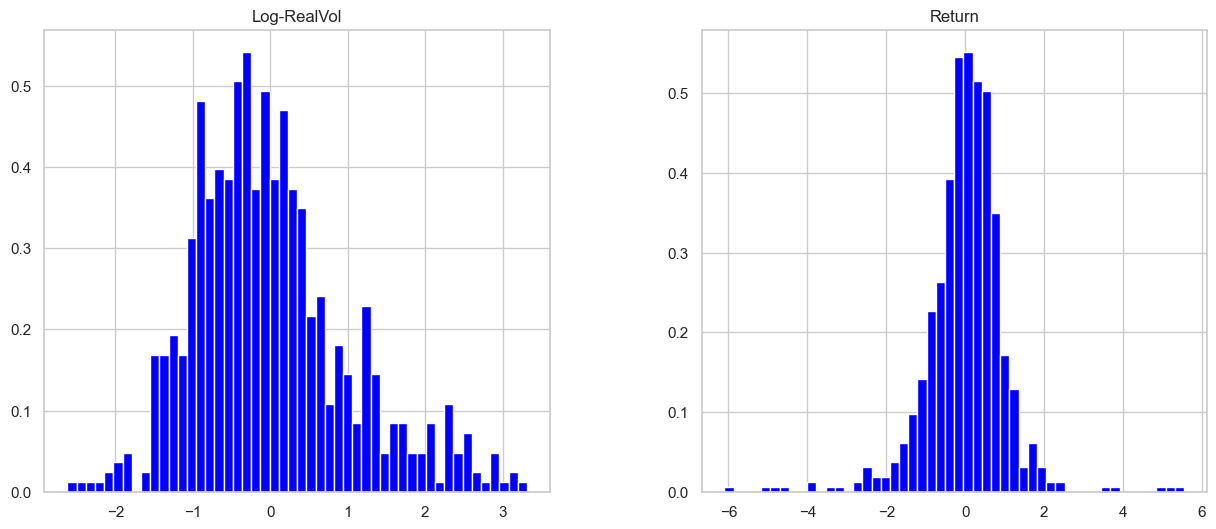

In [10]:
### feature engineering
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

#building the pipelines
general_pipeline = make_pipeline(StandardScaler()) # for returns
log_pipeline = make_pipeline(FunctionTransformer(func = np.log, inverse_func=np.exp, feature_names_out="one-to-one"),
                             StandardScaler()) # for realized volatility

preprocessing = ColumnTransformer([
    ("log", log_pipeline, ["Real_vol"])
], 
remainder = general_pipeline)

training_x_prepared = preprocessing.fit_transform(training_x)
training_x_prepared.shape

pd.DataFrame(training_x_prepared, columns = ["Log-RealVol", "Return"]).hist(bins = 50, 
                                                                            color = "blue", 
                                                                            density = True)
plt.show()

╒══════╤═════════╤═════════╤═════════╕
│      │ GARCH   │ EWMA    │ Max     │
╞══════╪═════════╪═════════╪═════════╡
│ MSE  │ 0.715%  │ 0.721%  │ 0.777%  │
├──────┼─────────┼─────────┼─────────┤
│ RMSE │ 8.455%  │ 8.489%  │ 8.816%  │
├──────┼─────────┼─────────┼─────────┤
│ MAE  │ 6.179%  │ 5.742%  │ 6.493%  │
├──────┼─────────┼─────────┼─────────┤
│ R2   │ 80.994% │ 80.842% │ 79.340% │
╘══════╧═════════╧═════════╧═════════╛


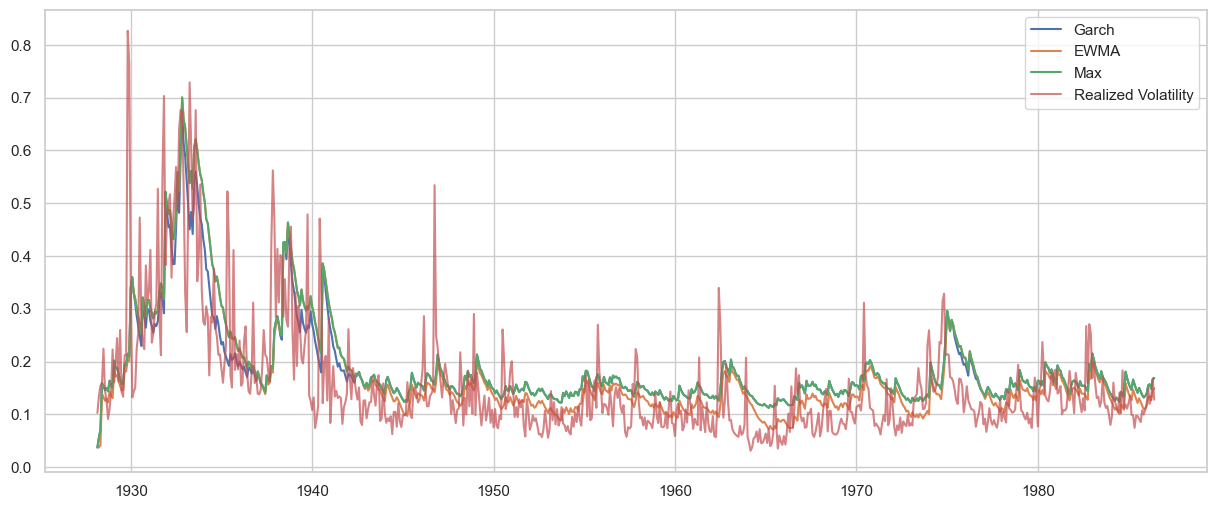

In [ ]:
#building the timeseries folds

#garch
initial_guess = [0.0001, 0.1, 0.8]
garch_est = GarchRegressor(initial_guess[0], initial_guess[1], initial_guess[2]) # estimating the training error
garch_est.fit(training_x) #training the model on all the training set 
predicted_vola_garch = garch_est.predict(training_x)

#ewma
ewma_est = EWMARegressor(lam = 0.9)
ewma_est.fit(training_x)
predicted_vola_ewma = ewma_est.predict(training_x)

#max between garch and ewma
max_est = MaxGarchEWMARegressor(garch_model = garch_est, ewma_model=ewma_est)
max_est.fit(training_x)
predicted_vola_max = max_est.predict(training_x)

# Training performances and plot
metrics_train = Metrics()
metrics_train.performance_metrics(predicted_vola_garch, training_y, "GARCH")
metrics_train.performance_metrics(predicted_vola_ewma, training_y, "EWMA")
metrics_train.performance_metrics(predicted_vola_max, training_y, "Max")
metrics_train.build_tabulate()

plt.plot(training_y.index, predicted_vola_garch, label = 'Garch')
plt.plot(training_y.index, predicted_vola_ewma, label = 'EWMA')
plt.plot(training_y.index, predicted_vola_max, label = 'Max')
plt.plot(training_y, label = 'Realized Volatility', alpha = 0.7)

plt.legend()
plt.show()

╒══════╤═════════╤═════════╤═════════╕
│      │ GARCH   │ EWMA    │ Max     │
╞══════╪═════════╪═════════╪═════════╡
│ MSE  │ 1.145%  │ 1.247%  │ 1.159%  │
├──────┼─────────┼─────────┼─────────┤
│ RMSE │ 10.702% │ 11.169% │ 10.764% │
├──────┼─────────┼─────────┼─────────┤
│ MAE  │ 6.620%  │ 6.663%  │ 6.725%  │
├──────┼─────────┼─────────┼─────────┤
│ R2   │ 70.265% │ 67.615% │ 69.921% │
╘══════╧═════════╧═════════╧═════════╛


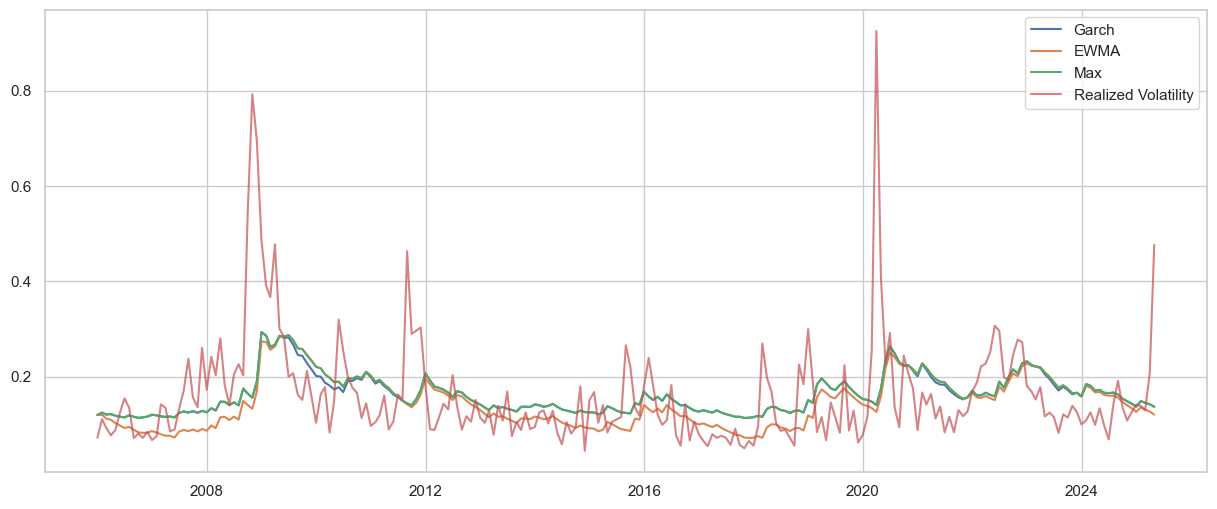

In [12]:
# computing the performance on the test set
test_garch = garch_est.predict(test_x)
test_ewma = ewma_est.predict(test_x)
test_max = max_est.predict(test_x)

metrics_test = Metrics()
metrics_test.performance_metrics(test_garch, test_y, "GARCH")
metrics_test.performance_metrics(test_ewma, test_y, "EWMA")
metrics_test.performance_metrics(test_max, test_y, "Max")
metrics_test.build_tabulate()

plt.plot(test_y.index, test_garch, label = 'Garch')
plt.plot(test_y.index, test_ewma, label = 'EWMA')
plt.plot(test_y.index, test_max, label = 'Max')
plt.plot(test_y, label = 'Realized Volatility', alpha = 0.7)

plt.legend()
plt.show()

In [13]:
## linear models
shrinkage_list = [1e-8, 1e-6, 1e-4, 0.01, 1, 10, 100, 1000]

simple_rg = LinearRegression()
lasso_rg = LassoCV(alphas = shrinkage_list, cv = 5)
ridge_rg = RidgeCV(alphas = shrinkage_list, cv = 5)

linear_models = [
    ('lr', simple_rg),
    ('lasso', lasso_rg),
    ('ridge', ridge_rg)
]
rmse_cross = {}
prediction_cross_val = {}
trained_model = {}

# Training the three linear models in the original variables
for tuple in linear_models:
    name = tuple[0]
    model = tuple[1]
    pipe = Pipeline([
        ('preprocessing', preprocessing),
        (name, model)
    ])
    #[name] = cross_val_score(pipe, training_x, training_y, cv = 5, scoring = 'neg_root_mean_squared_error')
    #trainig the model on the whole trainig set
    pipe.fit(training_x, training_y)
    prediction_cross_val[name] = pipe.predict(training_x)
    #storing the trained model
    trained_model[name] = pipe

╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│      │ GARCH   │ EWMA    │ Max     │ lr      │ lasso   │ ridge   │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ MSE  │ 0.715%  │ 0.721%  │ 0.777%  │ 0.590%  │ 0.590%  │ 0.600%  │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ RMSE │ 8.455%  │ 8.489%  │ 8.816%  │ 7.679%  │ 7.679%  │ 7.746%  │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ MAE  │ 6.179%  │ 5.742%  │ 6.493%  │ 5.081%  │ 5.081%  │ 4.943%  │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ R2   │ 80.994% │ 80.842% │ 79.340% │ 84.325% │ 84.325% │ 84.048% │
╘══════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╛


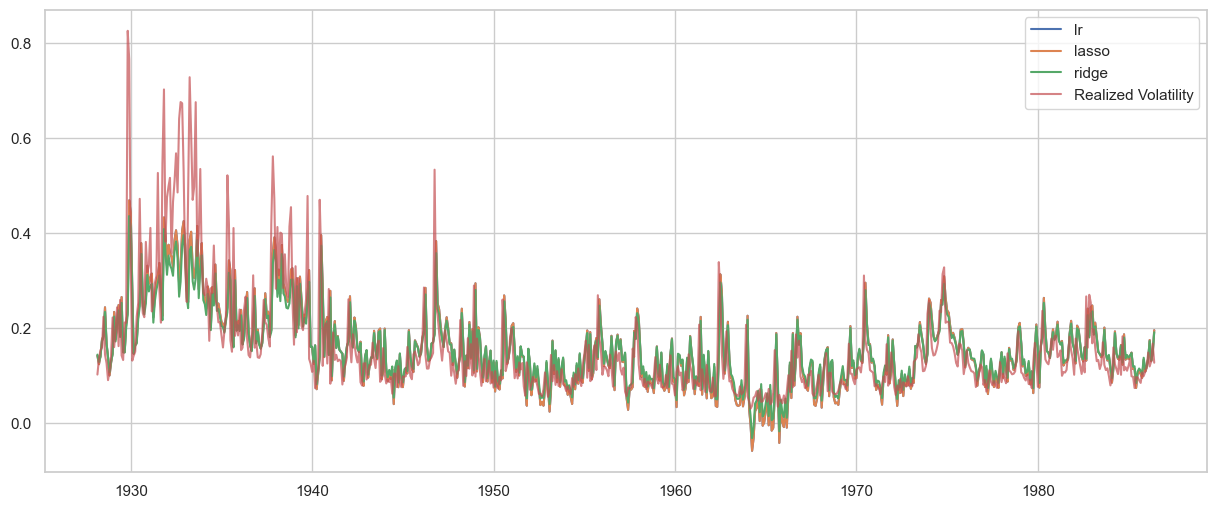

In [14]:
# evaluation of the performance of the model in the trainig set
#computing the Training Error for the three models
metrics_train.performance_metrics(prediction_cross_val["lr"], training_y, "lr")
metrics_train.performance_metrics(prediction_cross_val["lasso"], training_y, "lasso")
metrics_train.performance_metrics(prediction_cross_val["ridge"], training_y, "ridge")
metrics_train.build_tabulate()

#plotting the training results
for name in prediction_cross_val.keys():
    plt.plot(training_y.index, prediction_cross_val[name], label = f"{name}")
plt.plot(training_y, label = 'Realized Volatility', alpha = 0.7)

plt.legend()
plt.show()

╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│      │ GARCH   │ EWMA    │ Max     │ lr      │ lasso   │ ridge   │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ MSE  │ 1.145%  │ 1.247%  │ 1.159%  │ 0.756%  │ 0.756%  │ 0.745%  │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ RMSE │ 10.702% │ 11.169% │ 10.764% │ 8.696%  │ 8.696%  │ 8.630%  │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ MAE  │ 6.620%  │ 6.663%  │ 6.725%  │ 5.702%  │ 5.702%  │ 5.481%  │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ R2   │ 70.265% │ 67.615% │ 69.921% │ 80.369% │ 80.369% │ 80.663% │
╘══════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╛


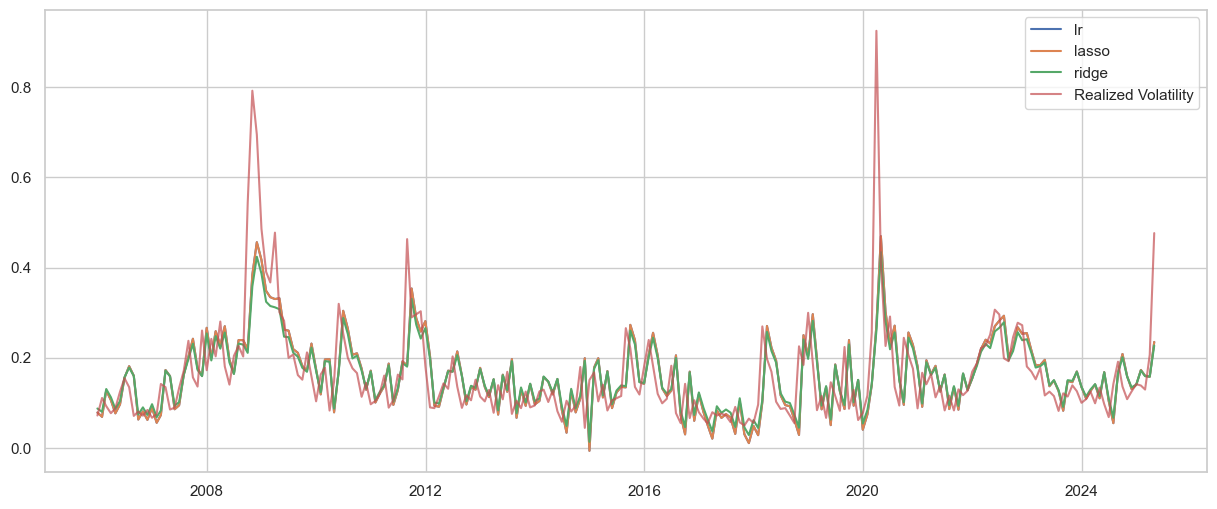

In [15]:
# eveluation of the model on the test set
lr_model = trained_model["lr"]
lasso_model = trained_model["lasso"]
ridge_model = trained_model["ridge"]

lr_preds = lr_model.predict(test_x)
lasso_preds = lasso_model.predict(test_x)
ridge_preds = ridge_model.predict(test_x)

metrics_test.performance_metrics(lr_preds, test_y, "lr")
metrics_test.performance_metrics(lasso_preds, test_y, "lasso")
metrics_test.performance_metrics(ridge_preds, test_y, "ridge")
metrics_test.build_tabulate()

plt.plot(test_y.index, lr_preds, label = 'lr')
plt.plot(test_y.index, lasso_preds, label = 'lasso')
plt.plot(test_y.index, ridge_preds, label = 'ridge')
plt.plot(test_y, label = 'Realized Volatility', alpha = 0.7)

plt.legend()
plt.show()


In [16]:
# TimeSeriesSplit (for time series data)
tscv = TimeSeriesSplit(n_splits=5)

#initializing rnd forest
rnd_forest = RandomForestRegressor(random_state=42)

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', rnd_forest)
])

# RandomizedSearchCV
param_grid = {
    'random_forest__n_estimators': randint(low=100, high=1000),
    'random_forest__max_depth': randint(low=5, high=50),
    'random_forest__min_samples_leaf': randint(low=2, high=20),
    'random_forest__max_features': ['auto', 'sqrt', 'log2'],
    'random_forest__min_samples_split': randint(low=2, high=20)
}

grid_search_forest = RandomizedSearchCV(
    full_pipeline,  
    param_grid,  
    cv=tscv,  
    n_iter=10,  
    random_state=42,
    scoring='neg_root_mean_squared_error'
)

# Fit the grid search
grid_search_forest.fit(training_x, training_y)

# Display the results
cv_res = pd.DataFrame(grid_search_forest.cv_results_).sort_values(by='mean_test_score', ascending=False)
cv_res.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__min_samples_leaf,param_random_forest__min_samples_split,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.730569,0.123541,0.053533,0.005960,40,log2,3,13,513,"{'random_forest__max_depth': 40, 'random_fores...",-0.103386,-0.063469,-0.052288,-0.040433,-0.040060,-0.059927,0.023385,1
3,0.698487,0.097697,0.044560,0.003839,42,sqrt,2,13,413,"{'random_forest__max_depth': 42, 'random_fores...",-0.104053,-0.063341,-0.052790,-0.041809,-0.040026,-0.060404,0.023379,2
1,0.243192,0.008465,0.021518,0.001163,25,log2,12,12,187,"{'random_forest__max_depth': 25, 'random_fores...",-0.107223,-0.065219,-0.054368,-0.038520,-0.040670,-0.061200,0.024967,3
5,0.802545,0.061536,0.056908,0.002087,46,log2,16,13,666,"{'random_forest__max_depth': 46, 'random_fores...",-0.113630,-0.067437,-0.056880,-0.038780,-0.041792,-0.063704,0.027035,4
0,0.011030,0.002108,0.000000,0.000000,43,auto,16,12,171,"{'random_forest__max_depth': 43, 'random_fores...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════════╕
│      │ GARCH   │ EWMA    │ Max     │ lr      │ lasso   │ ridge   │ rnd forest   │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════════╡
│ MSE  │ 0.715%  │ 0.721%  │ 0.777%  │ 0.590%  │ 0.590%  │ 0.600%  │ 0.336%       │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┤
│ RMSE │ 8.455%  │ 8.489%  │ 8.816%  │ 7.679%  │ 7.679%  │ 7.746%  │ 5.795%       │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┤
│ MAE  │ 6.179%  │ 5.742%  │ 6.493%  │ 5.081%  │ 5.081%  │ 4.943%  │ 3.568%       │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┤
│ R2   │ 80.994% │ 80.842% │ 79.340% │ 84.325% │ 84.325% │ 84.048% │ 91.072%      │
╘══════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════════╛


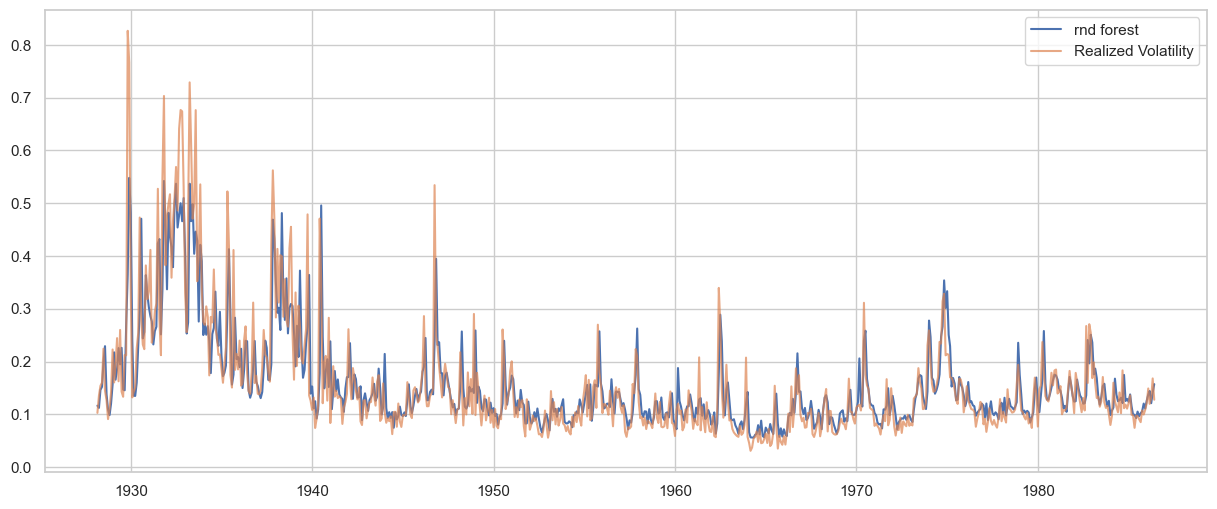

In [17]:
#testing the performance of the Random forest on the training set
rnd_forest_best = grid_search_forest.best_estimator_
rnd_forest_best.fit(training_x, training_y)
rnd_forest_training = rnd_forest_best.predict(training_x)

metrics_train.performance_metrics(rnd_forest_training, training_y, "rnd forest")
metrics_train.build_tabulate()

#plotting the training results

plt.plot(training_y.index, rnd_forest_training, label = "rnd forest")
plt.plot(training_y, label = 'Realized Volatility', alpha = 0.7)

plt.legend()
plt.show()

╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════════╕
│      │ GARCH   │ EWMA    │ Max     │ lr      │ lasso   │ ridge   │ rnd forest   │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════════╡
│ MSE  │ 1.145%  │ 1.247%  │ 1.159%  │ 0.756%  │ 0.756%  │ 0.745%  │ 0.735%       │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┤
│ RMSE │ 10.702% │ 11.169% │ 10.764% │ 8.696%  │ 8.696%  │ 8.630%  │ 8.571%       │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┤
│ MAE  │ 6.620%  │ 6.663%  │ 6.725%  │ 5.702%  │ 5.702%  │ 5.481%  │ 5.206%       │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┤
│ R2   │ 70.265% │ 67.615% │ 69.921% │ 80.369% │ 80.369% │ 80.663% │ 80.929%      │
╘══════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════════╛


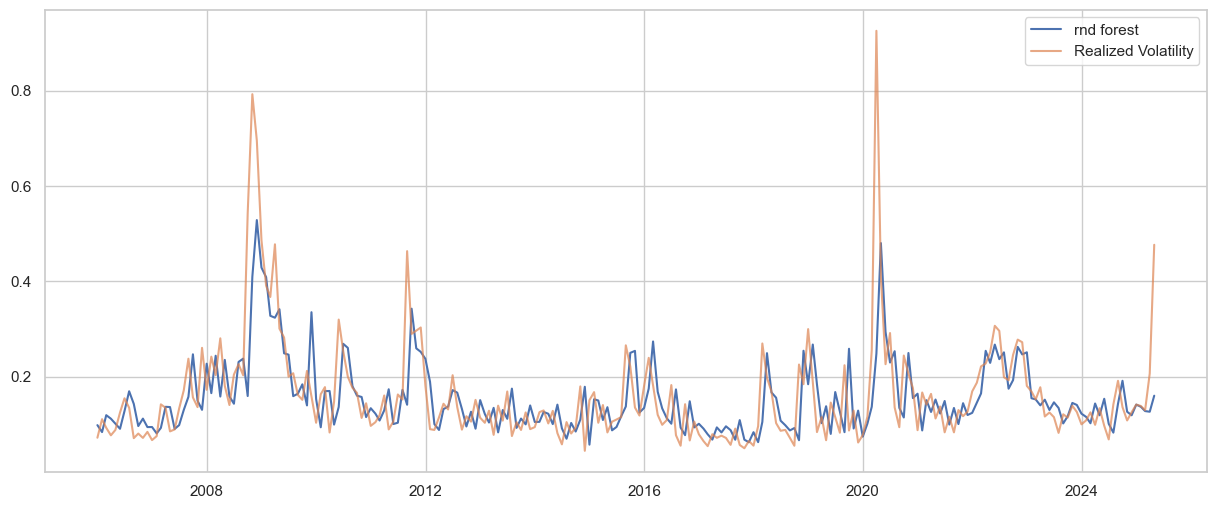

In [18]:
#testing the performance of the random forest on the test set

rnd_forest_test = rnd_forest_best.predict(test_x)

metrics_test.performance_metrics(rnd_forest_test, test_y, "rnd forest")
metrics_test.build_tabulate()

plt.plot(test_y.index, rnd_forest_test, label = 'rnd forest')
plt.plot(test_y, label = 'Realized Volatility', alpha = 0.7)

plt.legend()
plt.show()